*Course: Hypothesis Testing in Public Health  
Institute: Johns Hopkins University  
Presenter: John McGready*

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Sampling Distributions and Standard Errors

#### The Normal Distribution  
Generate a normal distribution with a given mean (165) and standard deviation (2.5) based on 50000 samples. Note that for a population we calculate the standard error of the sample means as st.dev / sqrt(50000).

165.010658040039 0.011206768120354437


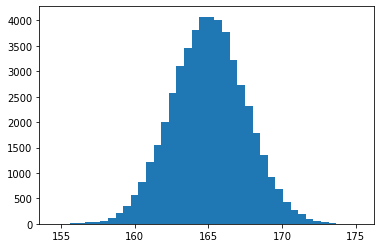

In [2]:
norm = np.random.normal(165,2.5,50000)
print(np.mean(norm), stats.sem(norm))
plt.hist(norm, bins=40);

In [3]:
def sample_norm_distribution(dist, sample_size=20, repeats=5000):
    """
    Sample from a distribution multiple times and return 
    an array containing the means from each sampling
    """
    arr = []
    for i in range(repeats):
        new_dist = np.random.choice(dist, size=sample_size, replace=True)
        arr.append(np.mean(new_dist))
    return arr

In [4]:
arr_20 = sample_norm_distribution(norm, sample_size=20)
arr_50 = sample_norm_distribution(norm, sample_size=50)
arr_100 = sample_norm_distribution(norm, sample_size=100)
arr_200 = sample_norm_distribution(norm, sample_size=200)

In the plot below, note that the median for all sampling distributions is (nearly) the same, is distributed "approximately" normal, and the center of the distribution agrees well with the "true" mean of 165. Moreover, as the size of the sample increases, from 20 to 200, the variability of the distribution of the means decreases.

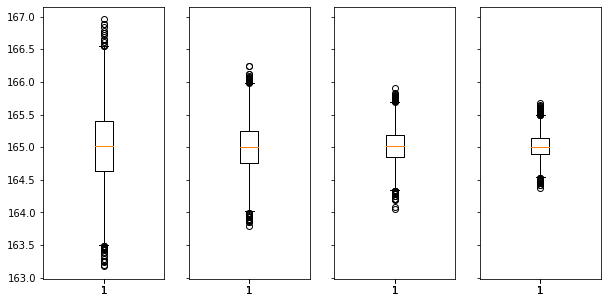

In [5]:
def plot_distributions(arr1, arr2, arr3, arr4):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 5))

    ax1.boxplot(arr1)
    ax2.boxplot(arr2)
    ax3.boxplot(arr3)
    ax4.boxplot(arr4);
    
plot_distributions(arr_20, arr_50, arr_100, arr_200)

#### Binomial Distribution  

First, we generate a binomial distribution of size `50000` with a probability of `0.25` for being positive (`1`).

In [6]:
from collections import Counter
binom = np.random.binomial(1, 0.25, 50000)
counter = Counter(binom)
print("Percentage positive cases:", counter[1] / 50000)

Percentage positive cases: 0.25178


In [7]:
def sample_binom_distribution(sample_size=20, repeats=5000):
    """
    Sample from a distribution multiple times and return 
    an array containing the means (percent positive) from each sampling
    """
    arr = []
    for i in range(repeats):
        binom = np.random.binomial(1, 0.25, size=sample_size)
        num_pos = Counter(binom)[1]
        arr.append(num_pos/sample_size)
    return arr

Note that, although the sample means were derived from repeated sampling from a binomial distribution, the distribution of the sample means is approximately normal with a standard deviation that decreases with increasing sample size. The standard error for the population means can be calculated as: sqrt((p*(1-p))/n).

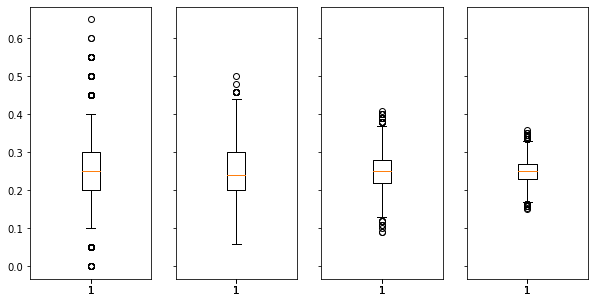

In [8]:
arr_bin_20 = sample_binom_distribution(sample_size=20)
arr_bin_50 = sample_binom_distribution(sample_size=50)
arr_bin_100 = sample_binom_distribution(sample_size=100)
arr_bin_200 = sample_binom_distribution(sample_size=200)
plot_distributions(arr_bin_20, arr_bin_50, arr_bin_100, arr_bin_200)

### Incidence Rate

In [9]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter

The data is available at https://www.kaggle.com/blastchar/telco-customer-churn. For our purposes, we will select a subset of the data. Specifically, the "survival" curve will be generated from persons who did not subscribe to `StreamingTV` and the target column `Churn` will be used as the "event" status with zero representing a censored event and one an actual event. The column `tenure` will represent the follow-up time.

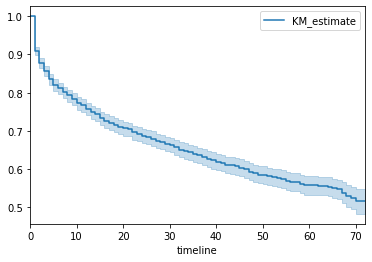

In [10]:
df = pd.read_csv("data/Telco-Customer-Churn.csv")
# Select StreamingTV as the event and tenure as duration
df_churn = df[df["StreamingTV"] == "No"][["tenure", "Churn"]]
df_churn["Churn"].replace(("No", "Yes"), (0, 1), inplace=True)
df_churn.sort_values(by=['tenure'], inplace=True)
# fit a Kaplan Meier model
kmf = KaplanMeierFitter()
kmf.fit(df_churn["tenure"], df_churn["Churn"])
kmf.plot();

In [11]:
def calc_ir(df):
    """
    Returns the incidence rate (person-time rate)
    """
    
    total_pers = df.shape[0]
    total_time = 0
    
    max_time = df['tenure'].max()
    
    for i in range(1, max_time+1):
        num_cens = df[(df['tenure'] == i) & (df['Churn'] == 0)].shape[0]
        num_case = df[(df['tenure'] == i) & (df['Churn'] == 1)].shape[0]
        
        total_time = total_time + (total_pers + 0.5*num_cens + 0.5*num_case)
        total_pers = total_pers - (num_cens+num_case)
    
    return sum(df['Churn']==1)/total_time
    
calc_ir(df_churn)

0.01314073278417532

In [12]:
def sample_survival_distribution(df, sample_size=50, repeats=5000):
    """
    Sample from a distribution multiple times and return 
    an array containing the incidence rate from each sampling
    """
    arr = []
    for i in range(repeats):
        df_sample = df.sample(n=sample_size)
        ir = calc_ir(df_sample)
        arr.append(ir)
    return arr

The distribution of the incidence rates, obtained from repeatedly sampling survival data, are approximately normally distributed with a decreasing variability as the sample size increases.

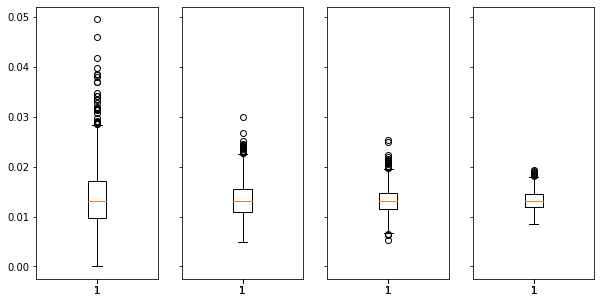

In [13]:
arr_surv_20 = sample_survival_distribution(df_churn, sample_size=20, repeats=1000)
arr_surv_50 = sample_survival_distribution(df_churn, sample_size=50, repeats=1000)
arr_surv_100 = sample_survival_distribution(df_churn, sample_size=100, repeats=1000)
arr_surv_200 = sample_survival_distribution(df_churn, sample_size=200, repeats=1000)
plot_distributions(arr_surv_20, arr_surv_50, arr_surv_100, arr_surv_200)

The `central limit theorem (CLT)` establishes that, in some situations, when independent random variables are added, their properly normalized sum tends toward a normal distribution (informally a bell curve) even if the original variables themselves are not normally distributed. For example, suppose that a sample is obtained containing many observations, each observation being randomly generated in a way that does not depend on the values of the other observations, and that the arithmetic mean of the observed values is computed. If this procedure is performed many times, the central limit theorem says that the probability distribution of the average will closely approximate a normal distribution. As can be seen from the results above, this holds true for means from a normal distribution, proportions from a binomial distribution and incidence rates calculated from survival data.

## 2. Confidence Intervals for Single Population Parameters

Recall that the CLT states that, if all possible samples of the same size `n`, were taken from the same population and a summary statistic were computed (mean, proportion, incidence rate) for each sample, then the distribution of the summary statistic values across these samples is approximately normal and centered at the mean, median, and mode. Moreover, this value would be the true value of the underlying parameter we are trying to estimate from our sample. In addition, most (95%) of the summary statistic values fall within two standard errors (SE) of the truth they are estimating.  

In other words, when we obtain an estimate (mean, proportion, incidence rate) based on a single random sampling and establish an interval given by estimate +/- 2 SE (estimated from our random sample), then this interval has a high likelihood of containing the unknown truth. This interval is known as the 95% confidence interval.

In [14]:
def calc_se(n=None, mean=None, stdev=None, prop=None, ir=None, events=None, fu_time=None, conf=90, st_type="normal"):
    """
    Return the standard error based on sample estimates
    of mean and standard deviation
    """
    d = {90:1.58, 95:2, 99:2.58}
    
    if st_type == "normal":
        se = stdev / np.sqrt(n)
        ci = (mean-d[conf]*se, mean+d[conf]*se)
        return se, ci
    elif st_type == "prop":
        se = np.sqrt((prop*(1-prop))/n)
        ci = (prop-d[conf]*se, prop+d[conf]*se)
        return se, ci
    elif st_type == "ir":
        se = np.sqrt(events)/fu_time
        ci = (ir-d[conf]*se, ir+d[conf]*se)
        return se, ci

print(calc_se(n=113, mean=123.6, stdev=12.9, conf=95, st_type="normal"))
print(calc_se(n=1000, prop=0.206, conf=95, st_type="prop"))
print(calc_se(ir=0.073, events=125, fu_time=1715, conf=95, st_type="ir"))

(1.2135299202148404, (121.17294015957032, 126.02705984042967))
(0.0127892142057282, (0.18042157158854358, 0.2315784284114564))
(0.006519148622448367, (0.05996170275510326, 0.08603829724489673))


The standard error estimate, as calculated above, quantifies how far, on average, the sample means based on 113 randomly sampled individuals will fall from the true population mean. In other words, this standard error estimate quantifies the variability in sample means based on random samples of 113, across the samples.  

The 95% confidence interval for the true mean is thus 123.6+/- 2 * 1.2 or (121.2, 126.0).

### Interpretation of a Confidence Interval.

A confidence interval for a population parameter, whether it be a mean, proportion, or incidence rate, is an interval that factors in the uncertainty in our estimate for the parameter. The uncertainty comes from the fact that we are using data from an imperfect sample. A confidence interval can be interpreted as a range of plausible values for the unknown truth that we can only estimate.

The data shown below can be downloaded from https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Inpatient (Retrieved April 12, 2020).

In [15]:
df_discharge = pd.read_csv("data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2016.csv")
df_discharge["Total Discharges"] = df_discharge["Total Discharges"].astype(str).str.replace(",", "").astype(int)

C:\Users\Michael\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
print("Dataframe shape:", df_discharge.shape)
print("Number of providers:", df_discharge["Provider Id"].unique().shape[0])

Dataframe shape: (197283, 12)
Number of providers: 3208


In [17]:
# Get discharge codes for urinary conditions
urinary_drg_codes = df_discharge[df_discharge['DRG Definition'].str.contains("URINARY")]["DRG Definition"].unique()

In [18]:
# List discharge codes and associated total cases with mean and standard deviation
for code in urinary_drg_codes:
    num = len(df_discharge[df_discharge["DRG Definition"] == code]["Total Discharges"])
    avg = np.mean(df_discharge[df_discharge["DRG Definition"] == code]["Total Discharges"])
    std = np.std(df_discharge[df_discharge["DRG Definition"] == code]["Total Discharges"])
    print(code[:10], int(num), int(avg), int(std))

673 - OTHE 172 15 5
674 - OTHE 71 14 4
687 - KIDN 2 13 0
689 - KIDN 2004 38 29
690 - KIDN 2629 54 47
693 - URIN 1 11 0
694 - URIN 415 16 7
696 - KIDN 107 15 5
698 - OTHE 1358 30 22
699 - OTHE 887 25 20
700 - OTHE 34 14 4


Next, we sample a subset of the dataframe, based on a specific ICD90 code, and repeatedly sample the subset. The function below returns an array with each entry representing the average discharges, the standard error associated with the sample, and the confidence interval.

In [19]:
# Select code 690
def sample_df(df, n=250, code="690", repeats=100):
    """
    Sample a subset of a dataframe based on the ICD code
    and return the mean, standard error and confidence intervals
    for the number of discharges.
    """
    arr= []
    for i in range(repeats):
        df_sample = df_discharge[df_discharge["DRG Definition"].str.startswith(code)].sample(n=n)
        avg = np.mean(df_sample["Total Discharges"])
        std = np.std(df_sample["Total Discharges"])
        res = list(calc_se(n=n, mean=avg, stdev=std, conf=95, st_type="normal"))
        arr.append([avg] + res)
    return arr

sample_df(df_discharge, repeats=1)

[[57.42, 2.874786670346167, (51.670426659307665, 63.16957334069234)]]

In [20]:
# Get 100 sample
arr_ci_100 = sample_df(df_discharge, n=250, code="690", repeats=100)

The graph below shows the different confidence intervals obtained from repeatedly sampling a population. Confidence intervals which contain the "true" population mean are colored black while confidence intervals which do not contain the "true" population mean are colored red. Out of the 100 confidence intervals, five are expected to be red. The black circles represent the mean for a specific sample. The blue horizontal line represents the "true" population mean calculated from all data.

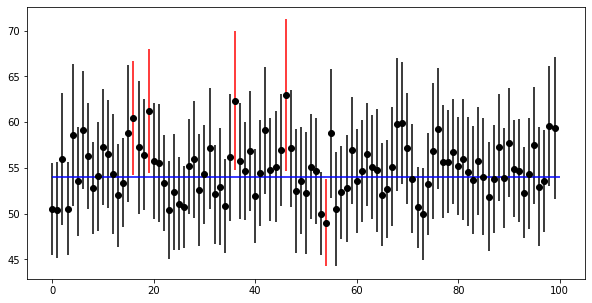

In [21]:
# Plot array of confidence intervals
plt.figure(figsize=(10,5))
for i in range(len(arr_ci_100)):
    if arr_ci_100[i][2][0]<54 and arr_ci_100[i][2][1]>54:
        colors = 'k'
    else:
        colors = 'r'
    plt.vlines(i, arr_ci_100[i][2][0], arr_ci_100[i][2][1], colors=colors, linestyles='solid')
    plt.plot(i, arr_ci_100[i][0], 'ko')
plt.hlines(54, 0, 100, linestyles='solid', colors='b')

From the graph above, it can be seen that most of the time the confidence interval for a single sample contains the population mean. The confidence interval provides a method for combining the best sample-based estimate of a population-level quantity with an estimate of the uncertainty in this quantity in regards to estimating the true, population-level, value.  
Note that with a small sample (n < 60), adjustments need to be made to the CLT-based approaches to estimating confidence intervals for means, proportions, and incidence rates.

## 3. Confidence Intervals for Population Comparison Measures

Estimation and interpretation of 95% confidence intervals for a mean difference between two populations may be `paired`, when the two samples drawn from two populations are linked systematically or `unpaired`, when the two samples are drawn from two independent, unlinked populations.

A paired t-test is used to compare two population means where you have two samples in which observations in one sample can be paired with observations in the other sample. Examples of where this might occur are:  
- Before-and-after observations on the same subjects (e.g. students’ diagnostic test results before and after a particular module or course).  
- A comparison of two different methods of measurement or two different treatments where the measurements/treatments are applied to the same subjects (e.g. blood pressure measurements using a stethoscope and a dynamap).  

**Note that for small sample sizes, the use of two SE's for the 95% confidence interval is not appropriate.**

### Confidence Intervals for Comparing Means of Continuous Outcomes Between Two Populations

Data from: Coates RA, Fanning MM, Johnson JK, Calzavara L. (1988) Assessment of generalized lymphadenopathy in AIDS research: the degree of clinical agreement. J. Clin. Epidemiol. (https://www.ncbi.nlm.nih.gov/pubmed/3339380). Since the 95% confidence interval does not contain the `null` value (0), the difference is significant.  
The `null` value is obtained when both sample means are the same.

In [22]:
def ci_continuous(diff=-2.75, sd=2.83, n=65, alpha=0.05):
    """
    Return 95% confidence interval for difference of means
    """
    t = round(stats.t.ppf(1-alpha/2, df=n-1),2)
    unc = sd/np.sqrt(n)
    return (round(diff-t*unc,2), round(diff+t*unc,2))

print(ci_continuous())

(-3.45, -2.05)


### Confidence Intervals for Binary Comparisons - Difference in Proportions

In [23]:
def ci_prop(p1=0.25, p2=0.16, n1=503, n2=497):
    """
    Return 95% confidence interval for difference of proportions
    """
    if n1+n2 < 60:
        t = round(stats.t.ppf(1-alpha/2, df=n1+n2-2),2)
    else:
        t = 2
    diff = p1-p2
    SE = np.sqrt((p1*(1-p1)/n1)+(p2*(1-p2)/n2))
    return (round(diff-t*SE,2), round(diff+t*SE,2))

ci_prop()

(0.04, 0.14)

### Confidence Intervals for Binary Comparisons - Ratio of Proportions and Odds Ratios

Using the following data:  
<img src="data/RR_HIV.png" width=500 height=250 />  

From the data shown below, the relative risk (rr) is significant since the 95% confidence interval does not contain the `null` value of 1. The ratio of two proportions (or odds) is one when they are identical.

In [24]:
def ci_rr(n1=127, n2=79, n3=376, n4=418):
    """
    Return confidence interval for relative risk
    """
    if n1+n2+n3+n4 < 60:
        t = round(stats.t.ppf(1-alpha/2, df=n1+n2+n3+n4-4),2)
    else:
        t = 2
    p1 = round(n1 / (n1+n3), 2)
    p2 = round(n2 / (n2+n4), 2)
    rr = p1/p2
    SE = np.sqrt(1/n1 - (1/(n1+n3)) + 1/n2 - (1/(n2+n4)))
    ci_log = (np.log(rr)-2*SE, np.log(rr)+2*SE)
    return np.round(np.exp(ci_log), 2)

ci_rr()

array([1.21, 2.02])

In [25]:
def ci_odds(n1=127, n2=79, n3=376, n4=418):
    """
    Return confidence interval for odds ratio
    """
    if n1+n2+n3+n4 < 60:
        t = round(stats.t.ppf(1-alpha/2, df=n1+n2+n3+n4-4),2)
    else:
        t = 2
    p1 = n1/n3
    p2 = n2/n4
    odds = p1/p2
    SE = np.sqrt(1/n1 + 1/n2 +1/n3 + 1/n4)
    ci_log = (np.log(odds)-2*SE, np.log(odds)+2*SE)
    return np.round(np.exp(ci_log), 2)

ci_odds()

array([1.3 , 2.46])

### Confidence Intervals for Incidence Rate Ratios

In [26]:
def ci_irr(events1=4587, py1=6351391, events2=5692, py2=5929663):
    """
    Return confidence interval for incidence ratios
    """
    if events1+events2 < 60:
        t = round(stats.t.ppf(1-alpha/2, df=events1+events2-2),2)
    else:
        t = 2
    ir1 = events1/py1
    ir2 = events2/py2
    irr = ir1/ir2
    SE = np.sqrt(1/events1 + 1/events2)
    ci_log = (np.log(irr)-2*SE, np.log(irr)+2*SE)
    return np.round(np.exp(ci_log), 2)

ci_irr()

array([0.72, 0.78])

## 4. Two-group Hypothesis Testing: General Concept and Comparing Means

The differences of two quantities, whose distribution is normal, have a normal distribution. The creation of  confidence interval for a difference uses the result from the CLT, coupled with the properties of a normal curve, to create an interval that (likely) includes the unknown truth for the population comparison measure.  
Alternatively, one could start with some competing, exhaustive possibilities for the unknown truth about the population comparison measure, and use data from samples to choose between these possibilities. For example:  

1. There is `no difference` between the two populations ($H_{0}$ or null hypothesis)
2. There is `a difference` between the two populations ($H_{A}$ or alternative hypothesis)  

Hypothesis testing starts with the assumption that $H_{0}$ is the truth. In other words, assume that $\mu_{1}$ - $\mu_{2}$ = 0 and see whether the measured difference is located at most plus or minus two standard errors (for 95%) from zero.  

The p-value is the probability of getting a study result as extreme or more extreme (as far or farther from the null value) by chance alone, if the null hypothesis is the underlying population truth.  

If p<0.05, then the 95% CI for the measure of interest (mean difference, difference in proportions, RR, etc.) will not include the null value.  
If p≥0.05, then the 95% CI for the measure of interest will include the null value.

<img src="data/paired_drs.png" width=500 height=250 />

Based on the data presented in the table, the difference between the means is -2.75 and, based on a sample size of 65 the standard error is $\frac{-2.75}{\frac{2.83}{\sqrt{65}}}$ which is approximately -7.86.  
In other words, our sample difference is -7.86 SE's below 0.  

The p-value is the probability of getting a sample mean difference of −2.75 or something more extreme if the true population mean is 0.  
Translated into standard errors, this is the probability of getting a result as far or farther than 7.86 standard errors from the mean of a normal curve.  

The proportion under the normal curve, with mean 0 that is more than 7.86 SE's from that mean (in both directions) is given by:

In [27]:
2*stats.norm.cdf(-7.86)

3.841334600852135e-15

In [28]:
def pv_means(n1=65, n2=None, mean1=-2.75, mean2=None, sd1=2.83, sd2=None, test="paired"):
    """
    Return p value for comparing means assuming unequal variances
    Assumes that values for paired test are n1, mean1, sd1 for differences
    """
    if test == "paired":
        SE = round(sd1/np.sqrt(n1), 2)
        t = round(mean1 / SE, 2)
        if n1 < 60:
            p = 2* (1 - stats.t.cdf(t,df=n1-1))
        else:
            p = 2*stats.norm.cdf(-abs(t))
    elif test == "unpaired":
        SE = np.sqrt(sd1**2/n1 + sd2**2/n2)
        t = round((mean1 - mean2) / SE, 2)
        p = 2*stats.norm.cdf(-abs(t))
    return t, p

print(pv_means())
print(pv_means(n1=9159, n2=3769, mean1=4.9, mean2=2.7, sd1=5.4, sd2=3.1, test="unpaired"))
print(pv_means(n1=64, n2=68, mean1=-5.7, mean2=-1.8, sd1=8.6, sd2=3.9, test="unpaired"))
print(pv_means(n1=10, mean1=4.8, sd1=4.6, test="paired"))

(-7.86, 3.841334600852135e-15)
(29.05, 1.5387969148456835e-185)
(-3.32, 0.000900174481184235)
(3.31, 0.009083911965112046)


## 5. Comparing Proportions and Incidence Rates Between Two Populations  

The two-sample z-test provides a method for getting a p-value for testing two competing hypotheses about the true proportions of a binary outcome between two populations where:

H0: p1 is equal to p2  
HA: p1 is not equal to p2  

Note that these two hypotheses can be expressed equivalently for risk differences, relative risks or odds ratios and as such only one *p* value is needed for all measures of association comparing binary outcomes between two populations.

In [29]:
def pv_prop(n1=None, n2=None, p1=None, p2=None):
    """
    Return p value for comparing proportions
    """
    SE = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z = (p1-p2)/SE
    p = 2*stats.norm.cdf(-abs(z))
    return p

print(pv_prop(n1=503, n2=497, p1=0.25, p2=0.16))
print(pv_prop(n1=180, n2=183, p1=0.07, p2=0.22))

0.0003870784547492949
3.16500157318385e-05


## 6. Comparing Proportions Between Two Populations: Chi-Square and Fisher’s Exact Test Approaches

The **chi-square** test is a general test for comparing binary (or categorical) outcomes across two or more populations. In the specific case of two proportions being compared across two populations, the results from the chi-square test and the two-sample z-test are identical: both depend on the same CLT-based result.

In [30]:
d = {'CD4 < 250': [127, 376, 503], 'CD4 >= 250': [79, 418, 497], 'Total': [206, 794, 1000]}
df = pd.DataFrame(data=d, index=["Respond", "Not Respond", "Total"])
df

,CD4 < 250,CD4 >= 250,Total
Respond,127,79,206
Not Respond,376,418,794
Total,503,497,1000


In [31]:
def chi_square(df):
    """
    Return p value for comparing proportions
    """
    n_cols = df.shape[0]-1 # not including 'total' column
    n_rows = df.shape[0]-1
    df_copy = df.copy()
    row_mult = np.array(df_copy.iloc[:-1:,-1] / df_copy.iloc[-1,-1]).reshape(2,1)
    col_total= np.array(df_copy.iloc[-1, :-1]).reshape(1,n_cols)
    observed = np.array(df_copy.iloc[:-1,:-1]).copy()
    expected = np.multiply(row_mult, col_total)
    chi = np.sum(np.square(observed - expected) / expected)
    return 1 - stats.chi2.cdf(chi, df=(n_rows-1)*(n_cols-1))

chi = chi_square(df)
print(chi)

0.0002555982313449112


The **log rank** test statistic compares estimates of the hazard functions of the two groups at each observed event time. It is constructed by computing the observed and expected number of events in one of the groups at each observed event time and then adding these to obtain an overall summary across all-time points where there is an event (https://en.wikipedia.org/wiki/Logrank_test).

In [32]:
#Treatment: 1 = treated, 0= PLacebo, Time of remission in weeks : t
#status : 1 = relapsed 0 = censored
x=[0]; y=[1]
df_lr=pd.DataFrame({'Treatment': 21*x+21*y,
                    't':[1,1,2,2,3,4,4,5,5,8,8,8,8,11,11,12,12,15,17,22,23,6,6,6,6,7,9,10,10,11,13,16,17,19,20,22,23,25,32,32,34,35],
                    'status':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0]})

In [33]:
group1=df_lr[df_lr['Treatment']==1]
group2=df_lr[df_lr['Treatment']==0]
T=group1['t']
E=group1['status']
T1=group2['t']
E1=group2['status']

In [34]:
from lifelines.statistics import logrank_test
results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()

## 7. (Hypothesis Testing) Comparing Means Between More Than Two Populations: Analysis of Variance (ANOVA)

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes. The null hypothesis assumes that there are **no** differences between the sample means while the alternative hypothesis states that **at least** two sample means are different.

In [35]:
df_plant = pd.read_csv("data/PlantGrowth.csv")
print("Number of groups:", df_plant['group'].nunique())
print("Group names:", df_plant['group'].unique())
df_plant.head()

Number of groups: 3
Group names: ['ctrl' 'trt1' 'trt2']


,Unnamed: 0,weight,group
0,1,4.17,ctrl
1,2,5.58,ctrl
2,3,5.18,ctrl
3,4,6.11,ctrl
4,5,4.50,ctrl


In [36]:
# Group data by group name
grps = pd.unique(df_plant.group.values)
data = {grp:df_plant['weight'][df_plant.group == grp] for grp in grps}

In [37]:
# Perform ANOVA
F, p = stats.f_oneway(data['ctrl'], data['trt1'], data['trt2'])
print(p)

0.0159099583256229
